# CSPB 3022: Introduction to Data Science Algorithms - Final Project
<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

#### Goal
The goal of my project is to use past home sale data to predict the sale price of homes in the Portland, OR area. This model may be applied to other markets with modifications to account for different market dynamics. This model will be built using multiple linear regression. I worked in the financial sector in the past and building pricing models is a very important aspect of asset valuation. If I choose to return to the financial sector in the future, understanding how to build a asset pricing model would be a very important skill to possess. <br>
#### Data Source
I sourced the bulk of my data from Kaggle. The original data can be found here: https://www.kaggle.com/datasets/threnjen/portland-housing-prices-sales-jul-2020-jul-2021. Per the description on the webpage, the data was scraped from Zillow using their API. The dataset contains information on home sales in the Portland, OR area from July 2020 to July 2021. Additionally, I sourced median income data by zip code from the United States Census Bureau. The original data can be found here: https://data.census.gov/cedsci/table?q=median%20income&g=0400000US41%248600000&tid=ACSST5Y2019.S1901. <br>
#### Data Description
The original dataset was formatted as a 77 MB .csv file. The original dataset contains 348 features (columns), the vast majority of which will not be used during this analysis, and 25,731 samples (rows) of data. As of now, I am using a single dataset that was gathered from one source. In the future I may add additional information (e.g., income data) to the dataset. <br>
#### Data Cleaning and EDA
The Portland home sale dataset is overall a very high quality dataset. I have done some basic data cleaning. As mentioned above, the original dataset contains 348 features. I went through each feature and determined whether it was worth keeping. I ended up keeping a total of 14 features, which are the following: 'address/city' (categorical); 'address/zipcode' (numeric); 'bathrooms' (numeric); 'bedrooms' (numeric); 'daysOnZillow' (numeric); 'homeStatus' (categorical); 'homeType' (categorical); 'livingArea' (numeric); 'lotSize' (numeric); 'latitude' (numeric); 'longitude' (numeric); 'propertyTaxRate' (numeric); 'yearBuilt' (numeric); 'price' (numeric). Additionally, I will focus my analysis on recently sold (rather than listed) single family homes. I removed any rows that were missing values from one or more of the features listed above. <br><br>
A brief description of each feature is as follows: 
* 'address/city' - city where the home sale occurred;
* 'address/zipcode' - zip code where the home sale occurred;
* 'latitude' - latitude location of the home;
* 'longitude' - longitude location of the home;
* 'medianIncome' - the median income for each zip code;
* 'geoCluster' - geographic regions generated through the k-nearest neighbor algorithm;
* 'bathrooms' - number of bathrooms in the home;
* 'bedrooms' - number of bathrooms in the home;
* 'daysOnZillow' - number of days the home was listed on Zillow prior to sale;
* 'homeStatus' - whether the home has sold or not;
* 'homeType' - type of residence (e.g., single family home or condominium);
* 'livingArea' - square footage of the home;
* 'lotSize' - square footage of the lot the home is located on;
* 'propertyTaxRate' - annual tax rate applied to the home;
* 'yearBuilt' - year in which the home was originally built;
* 'price' - price at which the home most recently sold; <br>
I eventually drop the 'homeStatus' and 'homeType' columns. I filtered the data by these columns above. I chose to only include recently sold single family homes from the dataset. The original dataset also included homes currently on the market but not yet sold. Since there may be large variance between a listing price and the sale price, I ommitted homes that have not yet sold. I also chose to only include single family homes, as the condo/apartment/townhouse market may have different economics than single family homes. The vast majority of samples in the dataset, approximately 87%, were single family homes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv('portland_housing.csv', dtype = 'unicode')

df = df[['address/city', 'address/zipcode', 'medianIncome', 'bathrooms', 'bedrooms', 'daysOnZillow', 'homeStatus', 'homeType', 'livingArea', 'lotSize', 'latitude', 'longitude', 'price', 
         'propertyTaxRate', 'yearBuilt']]

df = df[df.homeStatus == 'RECENTLY_SOLD']
df = df[df.homeType == 'SINGLE_FAMILY']

df = df.dropna()

df[['address/city', 'homeStatus', 'homeType']] = df[['address/city', 'homeStatus', 'homeType']].astype(str)

df[['address/zipcode', 'medianIncome', 'bedrooms', 'daysOnZillow', 'livingArea', 'lotSize', 'price', 'yearBuilt']] = df[['address/zipcode', 'medianIncome', 'bedrooms', 'daysOnZillow', 'livingArea', 'lotSize', 'price', 'yearBuilt']].astype(int)

df[['bathrooms', 'latitude', 'longitude', 'propertyTaxRate']] = df[['bathrooms', 'latitude', 'longitude', 'propertyTaxRate']].astype(float)

df = df[['address/city', 'address/zipcode', 'latitude', 'longitude', 'medianIncome', 'bathrooms', 'bedrooms', 'daysOnZillow', 'homeStatus', 'homeType', 'livingArea', 'lotSize', 'latitude', 'longitude', 
           'propertyTaxRate', 'yearBuilt', 'price']]

df['address/city'] = df['address/city'].str.upper()
df['homeStatus'] = df['homeStatus'].str.upper()
df['homeType'] = df['homeType'].str.upper()

In [3]:
print(df.nunique())

address/city          30
address/zipcode       63
latitude           17078
longitude          17152
medianIncome          62
bathrooms             24
bedrooms              12
daysOnZillow         364
homeStatus             1
homeType               1
livingArea          4078
lotSize             1363
latitude           17078
longitude          17152
propertyTaxRate        5
yearBuilt            144
price               3423
dtype: int64


In [4]:
df = df[['latitude', 'longitude', 'medianIncome', 'bathrooms', 'bedrooms', 'daysOnZillow', 'livingArea', 'lotSize', 'propertyTaxRate', 'yearBuilt', 'price']]
neg_vals = df[df['propertyTaxRate'] < 0].index #drop any negative values from the 'propertyTaxRate' feature
df.drop(neg_vals, inplace = True)

df = df.T.drop_duplicates().T

df.head()

,latitude,longitude,medianIncome,bathrooms,bedrooms,daysOnZillow,livingArea,lotSize,propertyTaxRate,yearBuilt,price
0,45.504250,-122.901779,62764.0,1.0,3.0,250.0,1636.0,5227.0,0.13,1984.0,26300.0
1,45.512848,-122.900154,62764.0,2.5,4.0,42.0,2056.0,5227.0,0.13,1990.0,484800.0
2,45.514427,-122.884934,62764.0,2.0,3.0,14.0,1334.0,5227.0,0.13,1994.0,450000.0
3,45.501087,-122.889572,62764.0,3.0,3.0,100.0,2200.0,2613.0,0.13,2015.0,531000.0
8,45.512680,-122.872147,62764.0,2.0,3.0,329.0,2114.0,8712.0,0.13,1973.0,374500.0


Below is a correlation matrix for the remaining features in my dataset ('bathrooms', 'bedrooms', 'daysOnZillow', 'livingArea', 'lotSize', 'propertyTaxRate', 'yearBuilt', and 'price'. As one may expect, 'livingArea' (square footage of the home), 'bathrooms' (number of bathrooms in the home), and 'bedrooms' (number of bedrooms in the home) are most highly correlated with the sale price of the home. We can already see candidates for removing from the model. 'yearBuilt' has a correlation of 0.025 and 'lotSize' has a correlation of 0.0099.

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

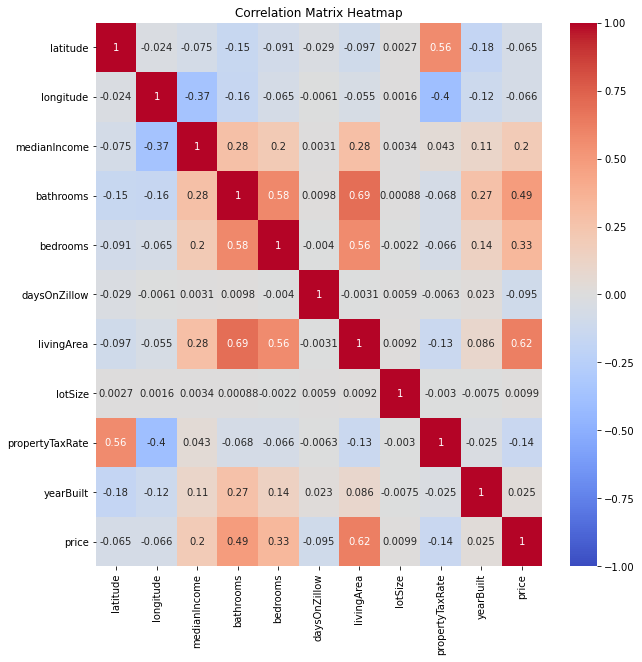

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix Heatmap')

The charts below display a few large outliers in terms of price, living area, number of bedrooms, and number of bathrooms. These outliers are so extreme that they may skew the outcomes of the model and thus will be removed fromt he dataset.

Text(0, 0.5, 'Home Sale Price')

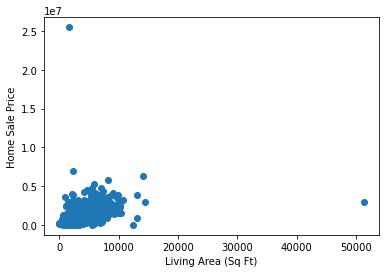

In [6]:
plt.scatter(df['livingArea'], df['price'])
plt.xlabel('Living Area (Sq Ft)')
plt.ylabel('Home Sale Price')

Text(0, 0.5, 'Home Sale Price')

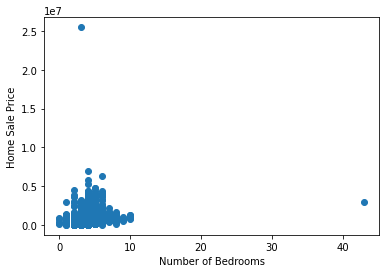

In [7]:
plt.scatter(df['bedrooms'], df['price'])
plt.xlabel('Number of Bedrooms')
plt.ylabel('Home Sale Price')

Text(0, 0.5, 'Home Sale Price')

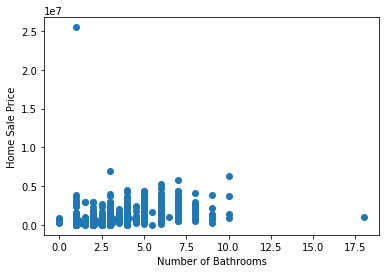

In [8]:
plt.scatter(df['bathrooms'], df['price'])
plt.xlabel('Number of Bathrooms')
plt.ylabel('Home Sale Price')

In [9]:
df = df[df.price != df['price'].max()] #removing outlier from 'price'
df = df[df.livingArea != df['livingArea'].max()] #removing outlier from 'livingArea'
df = df[df.bedrooms != df['bedrooms'].max()] #removing outlier from 'bedrooms'
df = df[df.bathrooms != df['bathrooms'].max()] #removing outlier from 'bathrooms'

Charting the distribution of the price, living area, bedrooms, and bathrooms features, there are still outliers which fall outside the upper and lower whisker limits. However, there is a natural progression of data points and no longer extreme outliers. Additionally, I have reproduced the scatter plots from above but with the outliers removed.

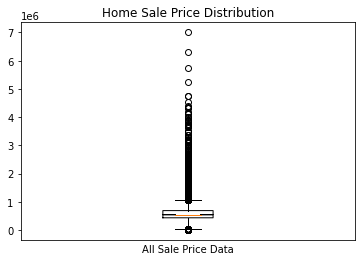

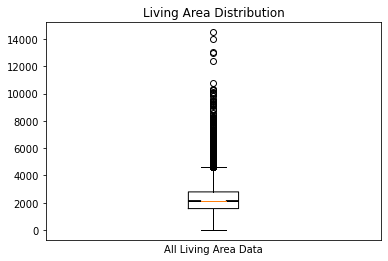

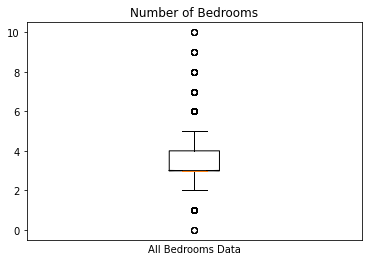

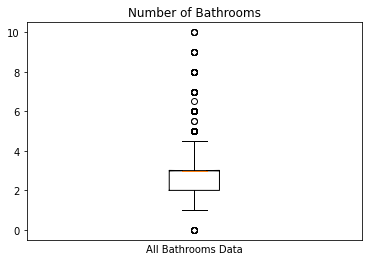

In [10]:
plt.boxplot(df['price'], notch = True)
plt.title('Home Sale Price Distribution')
plt.xlabel('All Sale Price Data')
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.show()

plt.boxplot(df['livingArea'], notch = True)
plt.title('Living Area Distribution')
plt.xlabel('All Living Area Data')
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.show()

plt.boxplot(df['bedrooms'], notch = True)
plt.title('Number of Bedrooms')
plt.xlabel('All Bedrooms Data')
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.show()

plt.boxplot(df['bathrooms'], notch = True)
plt.title('Number of Bathrooms')
plt.xlabel('All Bathrooms Data')
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.show()

Text(0, 0.5, 'Home Sale Price')

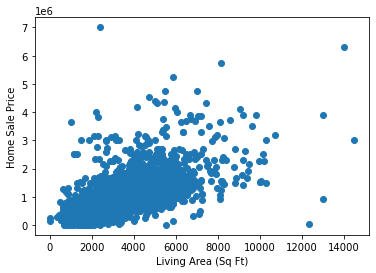

In [11]:
plt.scatter(df['livingArea'], df['price'])
plt.xlabel('Living Area (Sq Ft)')
plt.ylabel('Home Sale Price')

Text(0, 0.5, 'Home Sale Price')

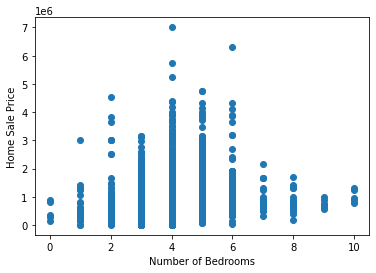

In [12]:
plt.scatter(df['bedrooms'], df['price'])
plt.xlabel('Number of Bedrooms')
plt.ylabel('Home Sale Price')

Text(0, 0.5, 'Home Sale Price')

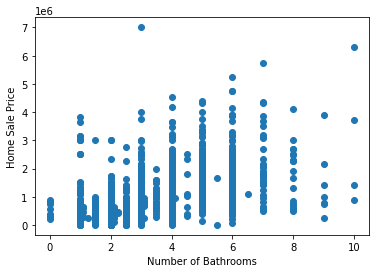

In [13]:
plt.scatter(df['bathrooms'], df['price'])
plt.xlabel('Number of Bathrooms')
plt.ylabel('Home Sale Price')

In [14]:
df_pp = df[['medianIncome', 'bathrooms', 'bedrooms', 'daysOnZillow', 'livingArea', 'propertyTaxRate', 'yearBuilt', 'price']]

A pairplot of select variables is shown below. Two key points are observable. Firstly, an effective job has been done removing extreme outliers from our data. Secondly, it can be seen visually that a number of important features appear to be highly correlated with each other. We will need to dive deeper into collinearity and how to handle any issues created by it.

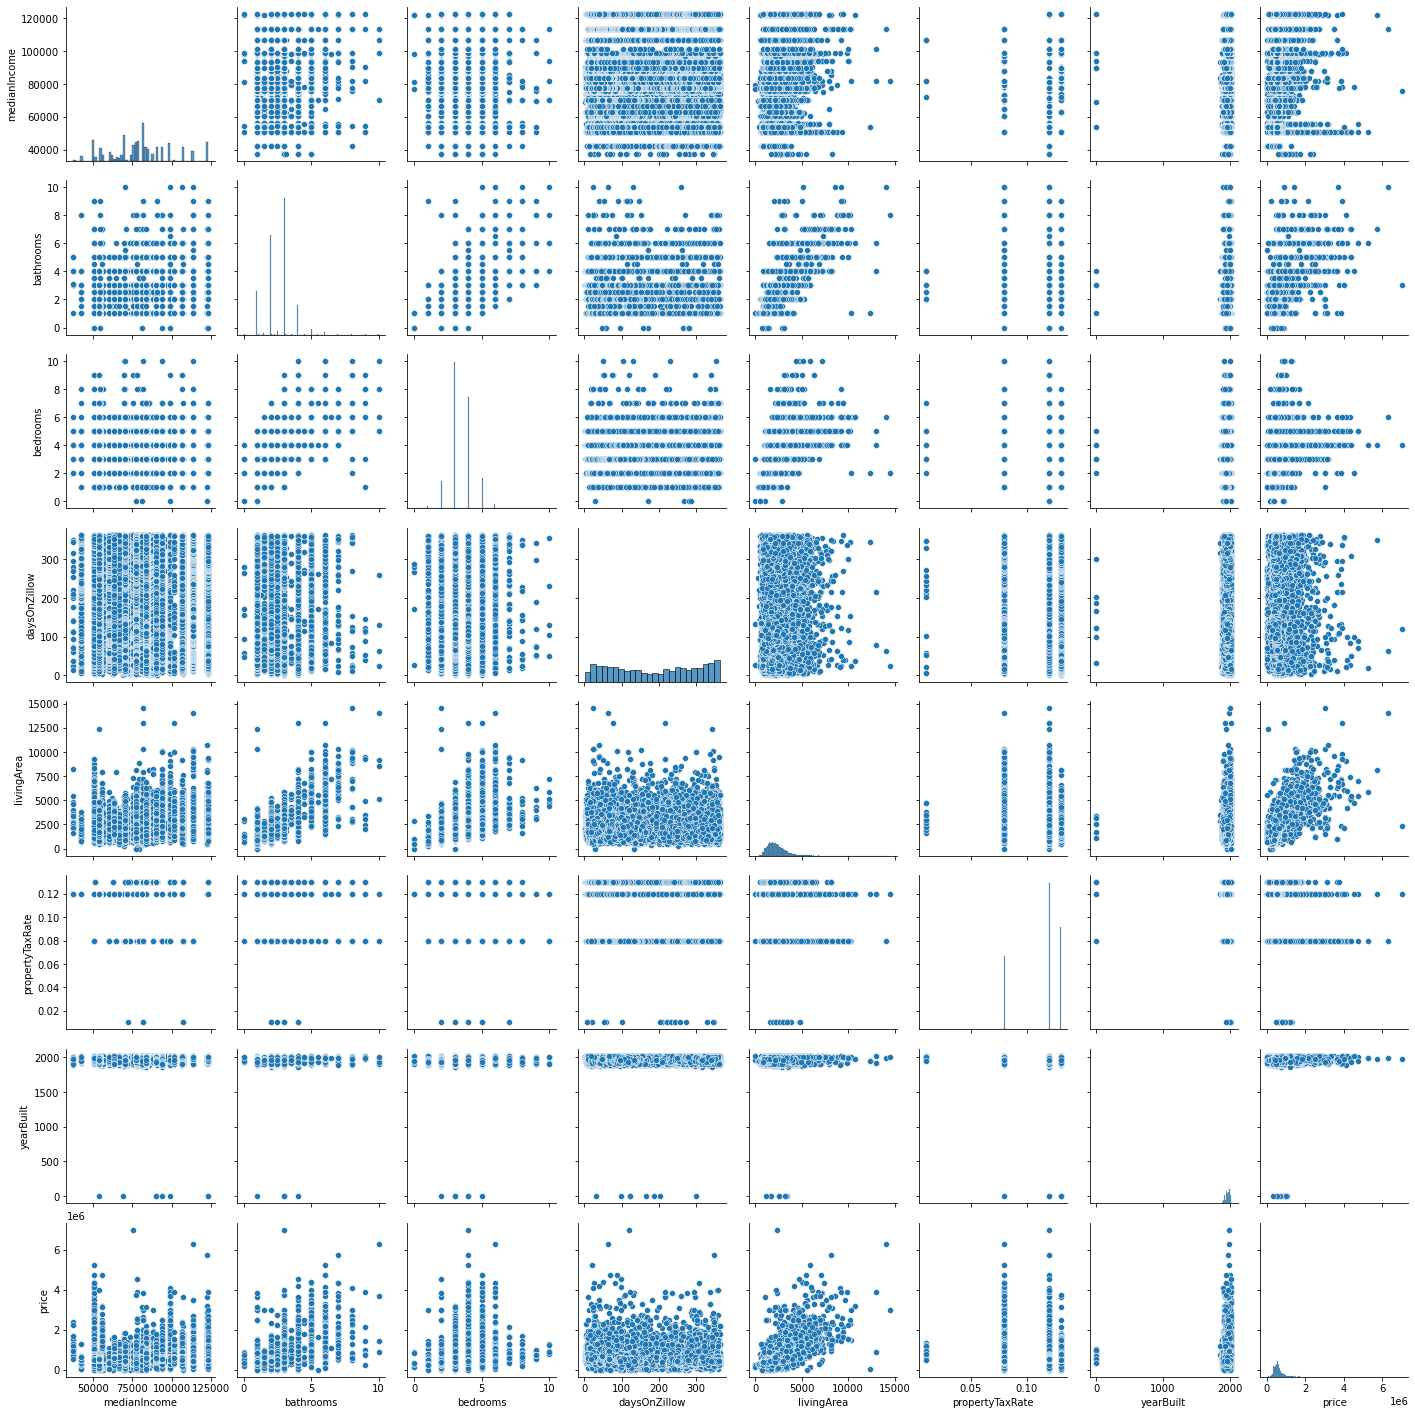

In [15]:
sns.pairplot(df_pp)

Below, the variance inflation factor ("VIF") of the three most highly correlated features in the correlation matrix above ('bathrooms', 'bedrooms', and 'livingArea') are evaluated. VIF is a statistical method that measures the multicollinearity between features. Generally, if a feature has a VIF value above 5, it is highly correlated to the other features. All three features examined have a VIF well above 5. One or more of these highly correlated features will need to be eliminated before selecting which features to include in our final model.

In [16]:
vif_vars = df[['medianIncome', 'bathrooms', 'bedrooms']]

vif_data = pd.DataFrame()
vif_data['feature'] = vif_vars.columns

vif_data['VIF'] = [variance_inflation_factor(vif_vars.values, i) for i in range(len(vif_vars.columns))]
print(vif_data)

        feature        VIF
0  medianIncome  11.720883
1     bathrooms  12.838020
2      bedrooms  19.149989


Below, feature importance, as calculated by the Lasso method, is used to select which of the three highly correlated features ('bathrooms', 'bedrooms', and 'livingArea') will be used in the model. It can be seen that 'livingArea' is the most important of these features, which conforms with the correlation matrix above. I will eliminate 'bathrooms' and 'bedrooms' from the model and proceed using 'livingArea'.

Lasso picked 1 variables and eliminated the other 2 variables


Text(0.5, 1.0, 'Feature Importance Using Lasso Model')

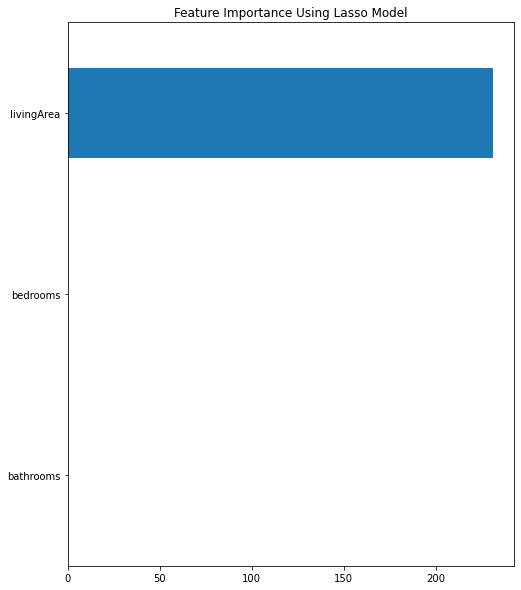

In [17]:
cor_feat = df[['bathrooms', 'bedrooms', 'livingArea']]
y_feat = df['price']

reg = LassoCV()
reg.fit(cor_feat, y_feat)
coef = pd.Series(reg.coef_, index = cor_feat.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature Importance Using Lasso Model")

The last step to be completed before moving onto the building of the model is converting the geographic data, namely the 'latitude' and 'longitude' features, into a simpler and more usable feature. It can be seen through regression analysis that simply using 'latitude' and 'longitude' provides an unsatisfactory result, with an Adjusted R-Squared well below 0.02. I use the k-nearest neighbors ("KNN") algorithm to group the location of sales into distinct geographic clusters. The KNN algorithm requires the number of desired clusters to be selected and requires some experimentation, which is carried out further below.

In [18]:
x_latlon = df[['latitude', 'longitude']]
x_latlon = sm.add_constant(x_latlon)
y_latlon = df['price']

latlon_model = sm.OLS(y_latlon, x_latlon).fit()

print(latlon_model.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     128.0
Date:                Tue, 09 Aug 2022   Prob (F-statistic):           5.52e-56
Time:                        04:40:37   Log-Likelihood:            -2.9241e+05
No. Observations:               20655   AIC:                         5.848e+05
Df Residuals:                   20652   BIC:                         5.848e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.235e+06   2.56e+06     -1.264      0.2

In [19]:
kmeans = KMeans(n_clusters = 20, init = 'k-means++')
kmeans.fit(df[df.columns[0:2]])
df['geoCluster'] = kmeans.fit_predict(df[df.columns[0:2]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(df[df.columns[0:2]])

In [20]:
dum_vars = pd.get_dummies(df['geoCluster'])
df = pd.concat([df, dum_vars], axis = 1)
df.columns = df.columns.map(str)

df = df.rename(columns = {'0': 'geoClust0', '1': 'geoClust1', '2': 'geoClust2', '3': 'geoClust3', '4': 'geoClust4', '5': 'geoClust5', '6': 'geoClust6', '7': 'geoClust7', '8': 'geoClust8', 
                            '9': 'geoClust9','10': 'geoClust10', '11': 'geoClust11', '12': 'geoClust12', '13': 'geoClust13', '14': 'geoClust14', '15': 'geoClust15', '16': 'geoClust16', 
                            '17': 'geoClust17', '18': 'geoClust18', '19': 'geoClust19'})

I ran the KNN algorithm for $k = 3, 5, 8, 10, 12, 20, 25$ (in a separate notebook). In the chart below, we can see that the increase in Adjusted R-Squared levels off from $k = 20$ to $k = 25$. We will therefore use $k = 20$ to group our latitude and longitude data into 20 separate geographic clusters. Through the KNN algorithm, we have successfully reduced the number of geographic clusters from the original 63 zip codes to 20 geographic clusters and maintained a very high F-statistic (F-statistic > 300). A dummy variable was created for each geographic cluster and added as a column to the dataset.

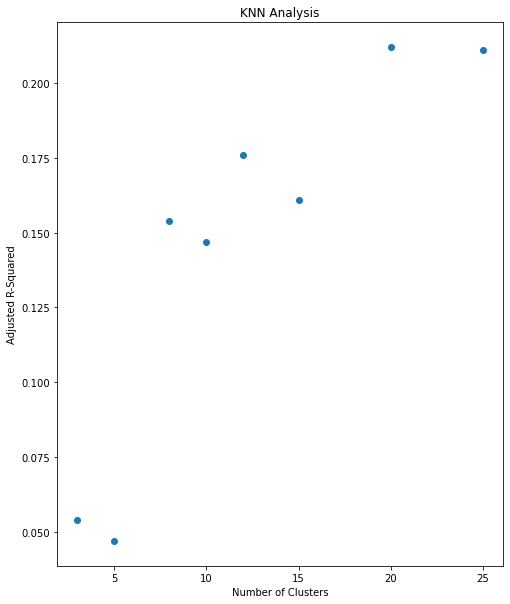

In [21]:
k = [3, 5, 8, 10, 12, 15, 20, 25]
adj_r2 = [0.054, 0.047, 0.154, 0.147, 0.176, 0.161, 0.212, 0.211]

plt.scatter(k, adj_r2)
plt.xlabel('Number of Clusters')
plt.ylabel('Adjusted R-Squared')
plt.title('KNN Analysis')

plt.show()

In [22]:
x_geo = df[['geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 'geoClust13', 
             'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19']]
x_geo = sm.add_constant(x_geo)
y_geo = df['price']

geo_model = sm.OLS(y_geo, x_geo).fit()

print(geo_model.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     292.2
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:40:41   Log-Likelihood:            -2.9007e+05
No. Observations:               20655   AIC:                         5.802e+05
Df Residuals:                   20635   BIC:                         5.803e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.727e+05   2126.228    269.355      0.0

Based on the correlation matrix above and additional analysis, there are several strong feature candidates to be to be evalued for the model (e.g., 'medianIncome', 'livingArea', and 'geoCluster'). The strong correlation between several of these variables could create issues when designing the model. Since the variables most strongly correlated with 'price', namely 'bathrooms', 'bedrooms', and 'livingArea', also display strong collinearity, I was forced to eliminate a few important features.  <br>

#### Model Creation, Results, and Analysis
As mentioned above, I use use a least squares multilinear regression model. Looking at the pair plots above, there seems to be a linear relationship between many of the variables, making multilinear regression a seemingly good fit. <br>
I will use forward stepwise selection to select which variables to include in the model. <br>

In [23]:
x_re1 = df[['livingArea']]
x_re1 = sm.add_constant(x_re1)
y_re1 = df['price']
re_model1 = sm.OLS(y_re1, x_re1).fit()

print(re_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 2.210e+04
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:40:42   Log-Likelihood:            -2.8502e+05
No. Observations:               20655   AIC:                         5.700e+05
Df Residuals:                   20653   BIC:                         5.701e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.703e+04   3968.237     19.412      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
x_re2 = df[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19']]
x_re2 = sm.add_constant(x_re2)
y_re2 = df['price']

re_model2 = sm.OLS(y_re2, x_re2).fit()

print(re_model2.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     1431.
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:40:42   Log-Likelihood:            -2.8355e+05
No. Observations:               20655   AIC:                         5.671e+05
Df Residuals:                   20634   BIC:                         5.673e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.1e+05   3766.487     29.199      0.0

In [25]:
x_re3 = df[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 
            'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19', 'daysOnZillow']]
x_re3 = sm.add_constant(x_re3)
y_re3 = df['price']

re_model3 = sm.OLS(y_re3, x_re3).fit()

print(re_model3.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     1423.
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:40:43   Log-Likelihood:            -2.8329e+05
No. Observations:               20655   AIC:                         5.666e+05
Df Residuals:                   20633   BIC:                         5.668e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.66e+05   4445.523     37.334   

In [26]:
x_re4 = df[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 
            'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19', 'daysOnZillow', 'medianIncome']]
x_re4 = sm.add_constant(x_re4)
y_re4 = df['price']

re_model4 = sm.OLS(y_re4, x_re4).fit()

print(re_model4.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1361.
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:40:43   Log-Likelihood:            -2.8327e+05
No. Observations:               20655   AIC:                         5.666e+05
Df Residuals:                   20632   BIC:                         5.668e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.112e+05   9240.844     22.856   

In [27]:
x_re5 = df[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 
            'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19', 'daysOnZillow', 'medianIncome', 'propertyTaxRate']]
x_re5 = sm.add_constant(x_re5)
y_re5 = df['price']

re_model5 = sm.OLS(y_re5, x_re5).fit()

print(re_model5.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     1308.
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:40:44   Log-Likelihood:            -2.8325e+05
No. Observations:               20655   AIC:                         5.665e+05
Df Residuals:                   20631   BIC:                         5.667e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.657e+05   2.32e+04     

Above, I performed forward stepwise selection to select the best feature in predicting the price of a real estate sale, as measured by its impact on Adjusted R-Squared, at each step of the process. The full forward stepwise process was performed in another notebook. <br>
By far the most impactful individual feature was 'livingArea', which an Adjusted R-Squared of approximately 0.517 (may slightly change upon different runnings of the linear regression model). The next most impact feature was 'geoCluster', which had an Adjusted R-Squared above 0.200. None of the other features had an Adjusted R-Squared above 0.100. For the two-feature model, adding 'geoCluster' resulted in the greatest increase in the Adjusted R-Squared, which was 0.581 with a model comprised of the 'livingArea' and 'geoCluster' features. The third variable added to the model was 'daysOnZillow', which only increased the Adjusted R-Squared to 0.591. Additional features from the dataset had little or no impact on the Adjusted R-Squared. <br><br>
Below is a list of variables and their respective Adjusted R-Squared, which can also be seen summarized in the chart further below:
* 'livingArea': 0.517;
* 'livingArea', 'geoCluster': 0.580;
* 'livingArea', 'geoCluster', 'daysOnZillow': 0.590;
* 'livingArea', 'geoCluster', 'daysOnZillow', 'medianIncome': 0.591;
* 'livingArea', 'geoCluster', 'daysOnZillow', 'medianIncome', 'propertyTaxRate': 0.591

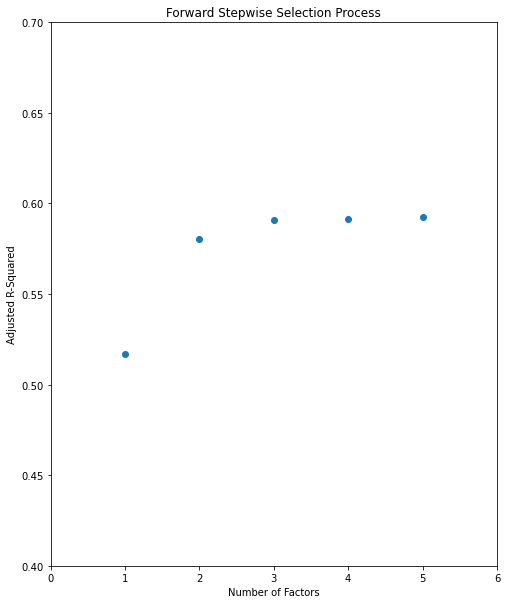

In [28]:
model1_r2 = re_model1.rsquared_adj
model2_r2 = re_model2.rsquared_adj
model3_r2 = re_model3.rsquared_adj
model4_r2 = re_model4.rsquared_adj
model5_r2 = re_model5.rsquared_adj

num_factors = [1, 2, 3, 4, 5]
adj_r2_lst = [model1_r2, model2_r2, model3_r2, model4_r2, model5_r2]

plt.scatter(num_factors, adj_r2_lst, label = 'Training Data')
plt.xlabel('Number of Factors')
plt.ylabel('Adjusted R-Squared')
plt.title('Forward Stepwise Selection Process')
plt.axis([0, 6, 0.40, 0.70])

plt.show()

In [29]:
re_test = df.sample(frac = 0.2, random_state = 200) #creates testing data by randomly selecting 20% of samples in the full dataset

x_re_test1 = re_test['livingArea']
x_re_test1Adj1 = sm.add_constant(x_re_test1)
y_re_test1 = re_test['price']
re_test1 = sm.OLS(y_re_test1, x_re_test1Adj1).fit()

x_re_test2 = re_test[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19']]
x_re_test1Adj2 = sm.add_constant(x_re_test2)
y_re_test2 = re_test['price']
re_test2 = sm.OLS(y_re_test2, x_re_test1Adj2).fit()

x_re_test3 = re_test[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19', 'daysOnZillow']]
x_re_test1Adj3 = sm.add_constant(x_re_test3)
y_re_test3 = re_test['price']
re_test3 = sm.OLS(y_re_test3, x_re_test1Adj3).fit()

x_re_test4 = re_test[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19', 'daysOnZillow', 'medianIncome']]
x_re_test1Adj4 = sm.add_constant(x_re_test4)
y_re_test4 = re_test['price']
re_test4 = sm.OLS(y_re_test4, x_re_test1Adj4).fit()

x_re_test5 = re_test[['livingArea', 'geoClust0', 'geoClust1', 'geoClust2', 'geoClust3', 'geoClust4', 'geoClust5', 'geoClust6', 'geoClust7', 'geoClust8', 'geoClust9', 'geoClust10', 'geoClust11', 'geoClust12', 'geoClust13', 'geoClust14', 'geoClust15', 'geoClust16', 'geoClust17', 'geoClust18', 'geoClust19', 'daysOnZillow', 'medianIncome', 'propertyTaxRate']]
x_re_test1Adj5 = sm.add_constant(x_re_test5)
y_re_test5 = re_test['price']
re_test5 = sm.OLS(y_re_test5, x_re_test1Adj5).fit()

test1_r2 = re_test1.rsquared_adj
test2_r2 = re_test2.rsquared_adj
test3_r2 = re_test3.rsquared_adj
test4_r2 = re_test4.rsquared_adj
test5_r2 = re_test5.rsquared_adj

test_factors = [1, 2, 3, 4, 5]
test_r2_lst = [test1_r2, test2_r2, test3_r2, test4_r2, test5_r2]

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
print(test_r2_lst)

[0.5186004488646756, 0.5617246416164023, 0.5718511950176779, 0.5718738299313009, 0.5724508618851838]


In the chart below, we can see that the Adjusted R-Squared values for the test data compare favorably to the Adjusted R-Squared for the training data (entire dataset), with the test data Adjusted R-Squared only lagging behind by a few hundredths of a unit. We can interpret this as our model not overfitting based on the training data. <br><br>
Below is a list of variables and their respective Adjusted R-Squared for the test, which can also be seen summarized in the chart further below:
* 'livingArea': 0.519;
* 'livingArea', 'geoCluster': 0.563;
* 'livingArea', 'geoCluster', 'daysOnZillow': 0.574;
* 'livingArea', 'geoCluster', 'daysOnZillow', 'medianIncome': 0.574;
* 'livingArea', 'geoCluster', 'daysOnZillow', 'medianIncome', 'propertyTaxRate': 0.576

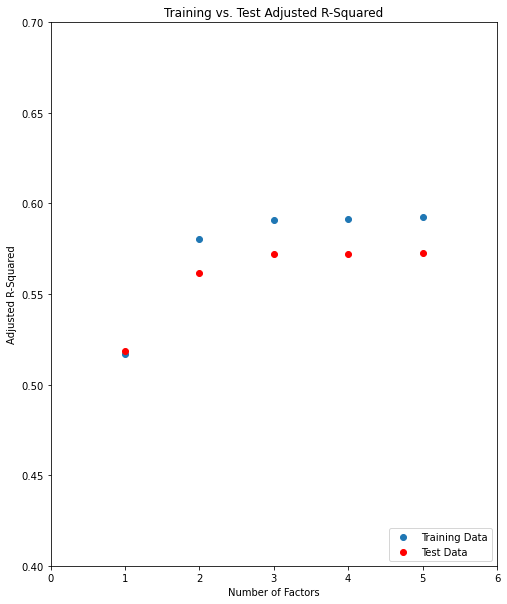

In [31]:
plt.scatter(num_factors, adj_r2_lst, label = 'Training Data')
plt.scatter(test_factors, test_r2_lst, color = 'red', label = 'Test Data')
plt.xlabel('Number of Factors')
plt.ylabel('Adjusted R-Squared')
plt.legend(['Training Data' , 'Test Data'], loc = 'lower right')
plt.title('Training vs. Test Adjusted R-Squared')
plt.axis([0, 6, 0.40, 0.70])

plt.show()

The mean absolute percentage error ("MAPE") calculates the average difference between predicted values, in this case our dependent variable 'price', and actual values. We can see from the analysis below that the MAPE ranges from 0.25 to 0.275, depending on the number of features. <br><br>
The scatter plot further below plots actual home sales prices on the x-axis and predicted home sales prices on the y-axis. We can see there are some extreme outliers, which could have a large impact on MAPE for our model.

In [32]:
y_true1 = y_re_test1
y_pred1 = re_test1.predict(x_re_test1Adj1)
mape1 = mean_absolute_percentage_error(y_true1, y_pred1)
print("MAPE (1 Feature): ", round(mape1, 3))

y_true2 = y_re_test2
y_pred2 = re_test2.predict(x_re_test1Adj2)
mape2 = mean_absolute_percentage_error(y_true2, y_pred2)
print("MAPE (2 Features): ", round(mape2, 3))

y_true3 = y_re_test3
y_pred3 = re_test3.predict(x_re_test1Adj3)
mape3 = mean_absolute_percentage_error(y_true3, y_pred3)
print("MAPE (3 Features): ", round(mape3, 3))

y_true4 = y_re_test4
y_pred4 = re_test4.predict(x_re_test1Adj4)
mape4 = mean_absolute_percentage_error(y_true4, y_pred4)
print("MAPE (4 Features): ", round(mape4, 3))

y_true5 = y_re_test5
y_pred5 = re_test5.predict(x_re_test1Adj5)
mape5 = mean_absolute_percentage_error(y_true5, y_pred5)
print("MAPE (5 Features): ", round(mape5, 3))

MAPE (1 Feature):  0.275
MAPE (2 Features):  0.254
MAPE (3 Features):  0.253
MAPE (4 Features):  0.253
MAPE (5 Features):  0.252


Text(0.5, 1.0, 'Predicted vs. True Home Sales Price')

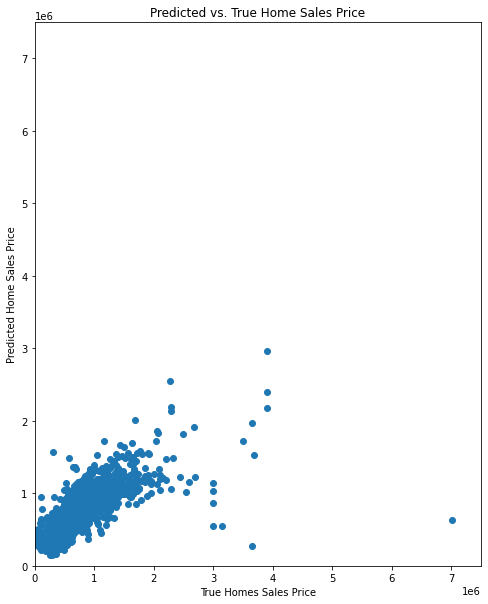

In [33]:
plt.scatter(y_true3, y_pred3, label = 'Training Data')
plt.axis([0, 7500000, 0, 7500000])
plt.xlabel('True Homes Sales Price')
plt.ylabel('Predicted Home Sales Price')
plt.title('Predicted vs. True Home Sales Price')

#### Discussion, Conclusion, and Write-Up
Based on the analysis of the various models above, the three feature multilinear regression model ("Model 3") containing the features 'livingArea', 'geoCluster', 'daysOnZillow' to predict 'price' is the best choice. Model 3 results in an Adjusted R-Squared value of 0.573 when run on the test data, which lags only slightly behind the Adjusted R-Squared values for the training data. Models with more than the three features in Model 3 produce little to no increase in Adjusted R-Squared values, so adding more features simply creates additional complexity without adding predictive value to the model. <br><br>
An Adjusted R-Squared value of 0.573 for Model 3 means that approximately 57.3% of the variance in 'price' can be explained by the features in Model 3. Or stated another way, 42.7% of the variance in 'price' is not explained by our model. From a business perspective, if we were building a pricing model to determine what price to list homes at, we would not be very pleased with this model. This point is further illustrated by the MAPE of Model 3, which is 25.2%. The home sales prices predicted by Model 3 were off by about 25.2% on average. This is not a very good prediction error and indicates that there are other variables not in our model that have meaningful impact on the ultimate price a home sells for.<br><br>
Homes are not a commodity, as each home has many unique features. Features such as a view of downtown, school district, a garden in the backyard, height of ceilings, or new appliances may have a meaningful effect on the price a home sells for. These factors can be difficult to quantify and include in a pricing model. <br><br>
One way to improve the model would be to have a more accurate method of representing location in the pricing model. One of the most important phrases in real estate is "location, location, location." I created 20 geographic clusters using the KNN algorithm. While these clusters did have a positive effect on the accuracy of the model, I think a more nuanced approach is needed. There were 63 different zip codes in the original dataset and each zip code likely contains many neighborhoods with their own pricing dynamics. Unfortunately, I was unable to capture these hyper-local dynamics as I do not have the computing power to run analysis on this level of data. A more powerful computer would likely have been able to create a more accurate pricing model by quantifying pricing dynamics on a hyper-local level. <br><br>
While I was not able to create as accurate of a pricing model as I wanted, I did gain insight into which variables are predictive and just as importantly, which variables provided little value when creating a pricing model.